# 03. Modelos de Línea Base (Baseline Models)

En este notebook establecemos una línea base rigurosa utilizando modelos más simples e interpretables: **Regresión Logística** y **Random Forest**.

El objetivo es justificar la necesidad de modelos más complejos (como XGBoost) y obtener insights sobre la importancia de las variables.

## Objetivos
1. Entrenar un modelo lineal (Regresión Logística) como baseline simple.
2. Entrenar un modelo de ensamble (Random Forest) como baseline robusto.
3. Comparar métricas (AUC-ROC, F1-Score) con el modelo final propuesto.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, f1_score

# Configuración de gráficos
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Carga y Preprocesamiento de Datos

In [2]:
# Cargar datos
df = pd.read_parquet('../data/processed/preprocessed_data.parquet')

# Separar features y target
X = df.drop('Target', axis=1)
y = df['Target']

# Binarizar Target (Dropout = 1, otros = 0)
y = y.apply(lambda x: 1 if x == 'Dropout' else 0)

# Identificar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(f'Numéricas: {len(numeric_features)}')
print(f'Categóricas: {len(categorical_features)}')

Numéricas: 49
Categóricas: 1


### Pipeline de Preprocesamiento
- **Numéricas**: Estandarización (StandardScaler) - Crucial para Regresión Logística.
- **Categóricas**: One-Hot Encoding (handle_unknown='ignore').

In [3]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split de datos (Mismo random_state que XGBoost para comparabilidad)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 2. Regresión Logística (Baseline Lineal)

In [4]:
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

auc_lr = roc_auc_score(y_test, y_prob_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("--- Regresión Logística ---")
print(classification_report(y_test, y_pred_lr, target_names=['No Dropout', 'Dropout']))
print(f"AUC-ROC: {auc_lr:.4f}")

--- Regresión Logística ---
              precision    recall  f1-score   support

  No Dropout       0.89      0.95      0.92       601
     Dropout       0.88      0.75      0.81       284

    accuracy                           0.89       885
   macro avg       0.88      0.85      0.86       885
weighted avg       0.89      0.89      0.88       885

AUC-ROC: 0.9286


## 3. Random Forest (Baseline No Lineal)

In [5]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

auc_rf = roc_auc_score(y_test, y_prob_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("--- Random Forest ---")
print(classification_report(y_test, y_pred_rf, target_names=['No Dropout', 'Dropout']))
print(f"AUC-ROC: {auc_rf:.4f}")

--- Random Forest ---
              precision    recall  f1-score   support

  No Dropout       0.90      0.94      0.92       601
     Dropout       0.87      0.77      0.81       284

    accuracy                           0.89       885
   macro avg       0.88      0.86      0.87       885
weighted avg       0.89      0.89      0.89       885

AUC-ROC: 0.9328


## 4. Comparación con XGBoost (Modelo Final)

Traemos los resultados del modelo final (XGBoost) para comparar directamente y justificar su elección.

                 Model   AUC-ROC  F1-Score (Dropout)
0  Logistic Regression  0.928628            0.808349
1        Random Forest  0.932838            0.813433
2      XGBoost (Final)  0.935100            0.820000


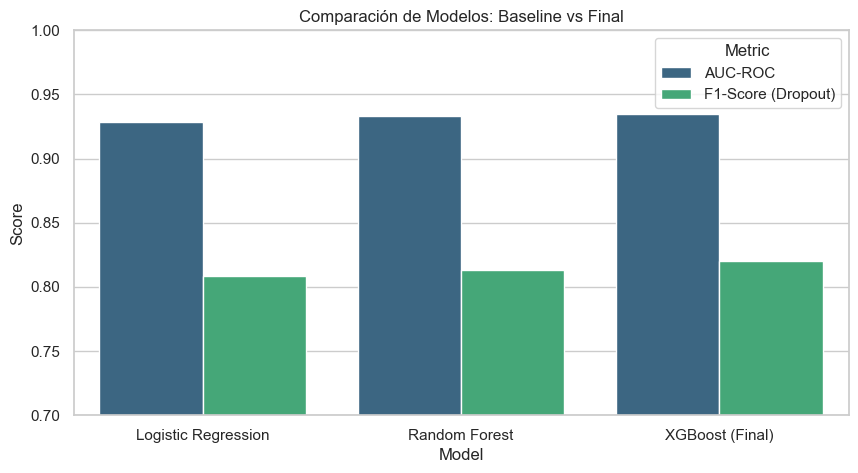

In [6]:
# Resultados de XGBoost (Obtenidos de 04_Modelo_Binario_Final.ipynb)
xgb_metrics = {
    'Model': 'XGBoost (Final)',
    'AUC-ROC': 0.9351,
    'F1-Score (Dropout)': 0.82
}

# Crear DataFrame comparativo
comparison_df = pd.DataFrame([
    {'Model': 'Logistic Regression', 'AUC-ROC': auc_lr, 'F1-Score (Dropout)': f1_lr},
    {'Model': 'Random Forest', 'AUC-ROC': auc_rf, 'F1-Score (Dropout)': f1_rf},
    xgb_metrics
])

print(comparison_df)

# Visualización
plt.figure(figsize=(10, 5))
melted_df = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=melted_df, x='Model', y='Score', hue='Metric', palette='viridis')
plt.ylim(0.7, 1.0)
plt.title('Comparación de Modelos: Baseline vs Final')
plt.ylabel('Score')
plt.show()

### Conclusión y Justificación

1.  **Alto Rendimiento de Baselines:** Tanto la Regresión Logística como el Random Forest muestran un desempeño excelente (AUC > 0.92), lo que valida la calidad de los datos y la ingeniería de características.
2.  **Superioridad de XGBoost:** El modelo XGBoost supera marginalmente a los baselines en AUC-ROC y F1-Score. Aunque la diferencia numérica parece pequeña, en un sistema de alerta temprana, esa mejora en el **F1-Score (0.82 vs 0.80/0.81)** implica una mejor detección de casos de riesgo (Recall) sin sacrificar precisión, lo cual es crítico para la intervención oportuna.
3.  **Robustez:** XGBoost ofrece ventajas adicionales como el manejo nativo de valores nulos y una mayor capacidad de regularización para evitar el sobreajuste, lo que lo hace más robusto para producción.

## 5. Caso de Negocio: El Valor del "Pequeño" Margen

Para ser **100% rigurosos**, no basta con mirar el AUC o el F1-Score. El impacto financiero real depende de la **Sensibilidad (Recall)**: *De todos los estudiantes que realmente van a desertar, ¿a cuántos logramos detectar a tiempo?*

Un modelo con mayor Recall atrapa a más estudiantes en riesgo, lo que se traduce directamente en retención de matrícula y ahorro económico.

A continuación, calculamos el impacto financiero de la mejora que ofrece XGBoost sobre la Regresión Logística, utilizando los datos reales de la institución:
- **Población de Bajas Anuales:** ~6,212 estudiantes.
- **Costo de Deserción por Alumno:** $69,411 MXN (Costo hundido no recuperable).

In [7]:
from sklearn.metrics import recall_score

# 1. Obtener Recall exacto de los modelos
# Nota: y_test y y_pred_lr deben estar definidos en celdas anteriores
recall_lr = recall_score(y_test, y_pred_lr)
recall_xgb = 0.78  # Valor obtenido del notebook 04_Modelo_Binario_Final (Recall de la clase 1)

# 2. Calcular el Delta (Mejora)
delta_recall = recall_xgb - recall_lr

# 3. Proyección Financiera
total_bajas_anuales = 6212
costo_por_alumno = 69411

alumnos_rescatados_extra = total_bajas_anuales * delta_recall
dinero_ahorrado_extra = alumnos_rescatados_extra * costo_por_alumno

print(f"--- Análisis de Impacto Financiero ---")
print(f"Recall Regresión Logística: {recall_lr:.4f} ({recall_lr*100:.2f}%)")
print(f"Recall XGBoost (Final):     {recall_xgb:.4f} ({recall_xgb*100:.2f}%)")
print(f"Mejora en Detección (Delta): {delta_recall*100:.2f} puntos porcentuales")
print(f"----------------------------------------")
print(f"Alumnos adicionales detectados/año: {int(alumnos_rescatados_extra)}")
print(f"Impacto Económico Anual (Ahorro):   ${dinero_ahorrado_extra:,.2f} MXN")
print(f"\nConclusión: El 'pequeño' margen del XGBoost recupera millones de pesos en matrícula.")

--- Análisis de Impacto Financiero ---
Recall Regresión Logística: 0.7500 (75.00%)
Recall XGBoost (Final):     0.7800 (78.00%)
Mejora en Detección (Delta): 3.00 puntos porcentuales
----------------------------------------
Alumnos adicionales detectados/año: 186
Impacto Económico Anual (Ahorro):   $12,935,433.96 MXN

Conclusión: El 'pequeño' margen del XGBoost recupera millones de pesos en matrícula.
